<a href="https://colab.research.google.com/github/silviolima07/Kaggle/blob/master/Analise_Viagens_Onibus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=119CJM4EnZ5XDikTz6_evjINNJBz9pt_2)

# Foram usados dados do Kaggle.
# Colunas foram selecionadas priorizando aquelas que podem ajudar entender o fluxo de bilhetes emitidos nos anos de 2019 e 2020.
# Periodo:
- 2019 (70%)
- 2020 (30%)
# Gráficos:
- de barras que fácilmente podem ser compreendidos
- sankey, indicando o fluxo da origem ao destino
- tabelas, mostrando valores estatísticos calculados

# Dados usados:
- passagens/viagens - https://www.kaggle.com/datasets/danlessa/brazil-interstate-bus-travels?resource=download

In [ ]:
!pip install ipympl --q
!pip install pySankey --q
!pip install highlight_text --q
#!pip install pygwalker --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 kB 8.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from datetime import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt
plt.rcParams["axes.formatter.limits"] = (-5, 12)
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact
import ipympl
%matplotlib widget
%matplotlib inline
from pySankey.sankey import sankey
import seaborn as sns

In [ ]:
from PIL import Image
import urllib
import matplotlib.font_manager as fm
from highlight_text import fig_text

In [ ]:
#import pygwalker as pyg # Tableau

In [ ]:
def value_counts_df(df, col):
    """
    Returns pd.value_counts() as a DataFrame

    Parameters
    ----------
    df : Pandas Dataframe
        Dataframe on which to run value_counts(), must have column `col`.
    col : str
        Name of column in `df` for which to generate counts

    Returns
    -------
    Pandas Dataframe
        Returned dataframe will have a single column named "count" which contains the count_values()
        for each unique value of df[col]. The index name of this dataframe is `col`.

    Example
    -------
    >>> value_counts_df(pd.DataFrame({'a':[1, 1, 2, 2, 2]}), 'a')
       count
    a
    2      3
    1      2
    """
    df = pd.DataFrame(df[col].value_counts())
    df.index.name = col
    df.columns = ['count']
    df = df.reset_index()
    df.columns = [col, 'counts'] # change column names
    return df

In [ ]:
def remove_outlier(df,col):
    # Calculate first and third quartile
    first_quartile = df[col].describe()['25%']
    third_quartile = df[col].describe()['75%']

    # Interquartile range
    iqr = third_quartile - first_quartile

    # Remove outliers
    data = df[(df[col] > (first_quartile - 3 * iqr)) &
            (df[col] < (third_quartile + 3 * iqr))]
    return data

In [ ]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
def total_values(df):
  cols = list(df.columns)
  for col in cols:
    print("\n\nColuna:",col,"\n",df[col].value_counts())

In [ ]:
def rem_time(d):
    s = ''
    s = str(d.year) + '-' + str(d.month) + '-' + str(d.day)
    return s

In [ ]:
usecols = ['data_emissao_bilhete', 'categoria_transporte', 'origem_destino_linha', 'ponto_origem_viagem',
       'ponto_destino_viagem','tipo_servico', 'data_viagem', 'tipo_gratitude',
       'tipo_viagem', 'numero_poltrona', 'valor_total', 'in_passagem_cancelada']

In [ ]:
df_01_2020 = pd.read_csv("/content/drive/MyDrive/Viagens/venda_passagem_01_2020/venda_passagem_01_2020.csv", sep=';',encoding = 'latin-1', on_bad_lines='skip', nrows=1000, usecols=usecols)

In [ ]:
df_01_2020.shape

(1000, 12)

In [ ]:
df_01_2020.columns

Index(['data_emissao_bilhete', 'categoria_transporte', 'origem_destino_linha',
       'ponto_origem_viagem', 'ponto_destino_viagem', 'tipo_servico',
       'data_viagem', 'tipo_viagem', 'numero_poltrona', 'tipo_gratitude',
       'valor_total', 'in_passagem_cancelada'],
      dtype='object')

In [ ]:
df_01_2020.dropna(inplace=True)

In [ ]:
df_01_2020.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
data_emissao_bilhete,1000,72,02-01-2020,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN
categoria_transporte,1000,2,Interestadual,990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
origem_destino_linha,1000,178,SAO PAULO(SP) - RIO DE JANEIRO(RJ),177,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ponto_origem_viagem,1000,116,SAO PAULO/SP,207,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ponto_destino_viagem,1000,121,SAO PAULO/SP,270,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tipo_servico,1000,6,Convencional com sanitário,653,NaN,NaN,NaN,NaN,NaN,NaN,NaN
data_viagem,1000,25,03-01-2020,68,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tipo_viagem,1000,1,Regular,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
numero_poltrona,1000.0,NaN,NaN,NaN,23.773,15.396705,1.0,11.0,23.0,35.0,99.0
tipo_gratitude,1000,8,Tarifa Normal - sem desconto,672,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_01_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   data_emissao_bilhete   1000 non-null   object 
 1   categoria_transporte   1000 non-null   object 
 2   origem_destino_linha   1000 non-null   object 
 3   ponto_origem_viagem    1000 non-null   object 
 4   ponto_destino_viagem   1000 non-null   object 
 5   tipo_servico           1000 non-null   object 
 6   data_viagem            1000 non-null   object 
 7   tipo_viagem            1000 non-null   object 
 8   numero_poltrona        1000 non-null   int64  
 9   tipo_gratitude         1000 non-null   object 
 10  valor_total            1000 non-null   float64
 11  in_passagem_cancelada  1000 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 93.9+ KB


In [ ]:
df_01_2020[['data_emissao_bilhete', 'data_viagem']]

,data_emissao_bilhete,data_viagem
0,03-12-2019,13-01-2020
1,18-01-2020,20-01-2020
2,17-01-2020,18-01-2020
3,22-01-2020,22-01-2020
4,30-12-2019,05-01-2020
...,...,...
995,06-01-2020,07-01-2020
996,09-01-2020,12-01-2020
997,29-12-2019,01-01-2020
998,15-01-2020,17-01-2020


In [ ]:
df_01_2020['valor_total'] = pd.to_numeric(df_01_2020['valor_total'], downcast='float')
#
df_01_2020['numero_poltrona'] = pd.to_numeric(df_01_2020['numero_poltrona'], downcast='unsigned')

#
df_01_2020['categoria_transporte'] = df_01_2020['categoria_transporte'].astype('category')
df_01_2020['origem_destino_linha'] = df_01_2020['origem_destino_linha'].astype('category')
df_01_2020['ponto_destino_viagem'] = df_01_2020['ponto_destino_viagem'].astype('category')
df_01_2020['tipo_gratitude'] = df_01_2020['tipo_gratitude'].astype('category')
df_01_2020['tipo_servico'] = df_01_2020['tipo_servico'].astype('category')

df_01_2020['in_passagem_cancelada'] = df_01_2020['in_passagem_cancelada'].astype('category')

In [ ]:
df_01_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   data_emissao_bilhete   1000 non-null   object  
 1   categoria_transporte   1000 non-null   category
 2   origem_destino_linha   1000 non-null   category
 3   ponto_origem_viagem    1000 non-null   object  
 4   ponto_destino_viagem   1000 non-null   category
 5   tipo_servico           1000 non-null   category
 6   data_viagem            1000 non-null   object  
 7   tipo_viagem            1000 non-null   object  
 8   numero_poltrona        1000 non-null   uint8   
 9   tipo_gratitude         1000 non-null   category
 10  valor_total            1000 non-null   float32 
 11  in_passagem_cancelada  1000 non-null   category
dtypes: category(6), float32(1), object(4), uint8(1)
memory usage: 54.4+ KB


In [ ]:
# create the dict of index names and optimized datatypes
dtypes = df_01_2020.dtypes
colnames = dtypes.index
types = [i.name for i in dtypes.values]
column_types = dict(zip(colnames, types))
#
parse_date = ['data_emissao_bilhete', 'data_viagem']

In [ ]:
nrows = 1000000

# Colunas selecionadas e tipos de colunas definidos.
# Serão lidos 4 datasets com dados de bilhetes de viagens nos anos de 2019 e 2020.

In [ ]:
df_01_2020 = pd.read_csv("/content/drive/MyDrive/Viagens/venda_passagem_01_2020/venda_passagem_01_2020.csv", sep=';',encoding = 'latin-1', on_bad_lines='skip', dtype=column_types, parse_dates=parse_date, usecols=usecols, nrows=nrows)

In [ ]:
df_01_2020.shape

(1000000, 12)

In [ ]:
df_12_2019 = pd.read_csv("/content/drive/MyDrive/Viagens/venda_passagem_12_2019/venda_passagem_12_2019.csv", sep=';',encoding = 'latin-1', on_bad_lines='skip', dtype=column_types, parse_dates=parse_date, usecols=usecols, nrows=nrows)

In [ ]:
df_12_2019.shape

(1000000, 12)

In [ ]:
df_11_2019 = pd.read_csv("/content/drive/MyDrive/Viagens/venda_passagem_11_2019/venda_passagem_11_2019.csv", sep=';',encoding = 'latin-1', on_bad_lines='skip', dtype=column_types, parse_dates=parse_date, usecols=usecols, nrows=nrows)

In [ ]:
df_11_2019.shape

(1000000, 12)

In [ ]:
df_03_2019 = pd.read_csv("/content/drive/MyDrive/Viagens/venda_passagem_03_2019/venda_passagem_03_2019.csv", sep=';',encoding = 'latin-1', on_bad_lines='skip', dtype=column_types, parse_dates=parse_date, usecols=usecols, nrows=nrows)

In [ ]:
df_03_2019.shape

(1000000, 12)

In [ ]:
df_viagem = pd.concat([df_03_2019, df_11_2019, df_12_2019, df_01_2020], axis=0)

In [ ]:
df_viagem.shape

(4000000, 12)

In [ ]:
df_viagem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   data_emissao_bilhete   datetime64[ns]
 1   categoria_transporte   object        
 2   origem_destino_linha   object        
 3   ponto_origem_viagem    object        
 4   ponto_destino_viagem   object        
 5   tipo_servico           object        
 6   data_viagem            datetime64[ns]
 7   tipo_viagem            object        
 8   numero_poltrona        uint8         
 9   tipo_gratitude         object        
 10  valor_total            float32       
 11  in_passagem_cancelada  object        
dtypes: datetime64[ns](2), float32(1), object(8), uint8(1)
memory usage: 354.8+ MB


In [ ]:
df_viagem.head()

,data_emissao_bilhete,categoria_transporte,origem_destino_linha,ponto_origem_viagem,ponto_destino_viagem,tipo_servico,data_viagem,tipo_viagem,numero_poltrona,tipo_gratitude,valor_total,in_passagem_cancelada
0,2019-03-21,Interestadual,FLORIANOPOLIS(SC) - SAO PAULO(SP),JOINVILLE/SC,SAO PAULO/SP,Convencional com sanitário,2019-03-30,Regular,2,Tarifa Normal - sem desconto,229.899994,NÃO
1,2019-03-15,Interestadual,FLORIANOPOLIS(SC) - CAMPINAS(SP),BALNEARIO PICARRAS/SC,SAO PAULO/SP,Convencional com sanitário,2019-03-17,Regular,61,Tarifa Normal - sem desconto,141.000000,NÃO
2,2019-05-03,Interestadual,BALNEARIO CAMBORIU(SC) - SAO PAULO(SP),JOINVILLE/SC,SAO PAULO/SP,Convencional com sanitário,2019-06-03,Regular,12,Tarifa Normal - sem desconto,96.769997,NÃO
3,2019-03-16,Interestadual,FLORIANOPOLIS(SC) - SAO PAULO(SP),JOINVILLE/SC,SAO PAULO/SP,Convencional com sanitário,2019-03-17,Regular,47,Tarifa Normal - sem desconto,109.430000,NÃO
4,2019-01-18,Interestadual,BALNEARIO CAMBORIU(SC) - SAO PAULO(SP),BALNEARIO PICARRAS/SC,SAO PAULO/SP,Convencional com sanitário,2019-04-03,Regular,2,Tarifa Normal - sem desconto,103.059998,NÃO


In [ ]:
df_viagem = df_viagem.loc[df_viagem.valor_total >= 0]

In [ ]:
temp = df_viagem['origem_destino_linha'].str.split(' - ',expand=True)


In [ ]:
temp[1]

0         SAO PAULO(SP)
1          CAMPINAS(SP)
2         SAO PAULO(SP)
3         SAO PAULO(SP)
4         SAO PAULO(SP)
              ...      
999995     PARNAIBA(PI)
999996     CAMPINAS(SP)
999997      GOIANIA(GO)
999998     PARNAIBA(PI)
999999        NATAL(RN)
Name: 1, Length: 3999969, dtype: object

In [ ]:
temp = df_viagem['origem_destino_linha'].str.split(' - ',expand=True)
df_viagem['origem_linha'] = temp[0]
df_viagem['destino_linha']= temp[1]

In [ ]:
df_viagem['origem_destino_linha'] = df_viagem.origem_destino_linha.str.strip().str.replace(' ','')

In [ ]:
#df_viagem[['origem_destino_linha', 'origem_linha', 'destino_linha']].head()

In [ ]:
orig = df_viagem['origem_linha'].str.split('(', expand=True)
orig.rename(columns={0: "cidade_origem_linha", 1:"uf_origem_linha" }, inplace=True)
orig['uf_origem_linha'] = orig.uf_origem_linha.str.replace(')','')


In [ ]:
#orig.head()

In [ ]:
dest = df_viagem['destino_linha'].str.split('(', expand=True)
dest.rename(columns={0: "cidade_destino_linha", 1:"uf_destino_linha" }, inplace=True)
dest['uf_destino_linha'] = dest.uf_destino_linha.str.replace(')','')

In [ ]:
#dest.head()

In [ ]:
df_viagem["cidade_origem_linha"] = orig.cidade_origem_linha.str.strip()
df_viagem['uf_origem_linha'] = orig.uf_origem_linha.str.strip()
#
df_viagem["cidade_destino_linha"] = dest.cidade_destino_linha.str.strip()
df_viagem['uf_destino_linha'] = dest.uf_destino_linha.str.strip()

In [ ]:
#df_viagem[['origem_destino_linha', 'uf_origem_linha','destino_linha', 'cidade_destino_linha', 'uf_destino_linha']]

In [ ]:
df_viagem['ponto_destino_viagem']= df_viagem.ponto_destino_viagem.str.rstrip().str.replace(' ', '-')

In [ ]:
#df_viagem['ponto_destino_viagem'].head()

In [ ]:
df_viagem['tipo_gratitude'].loc[df_viagem.tipo_gratitude.isnull()]

154936    NaN
222453    NaN
269970    NaN
658600    NaN
658601    NaN
738540    NaN
17906     NaN
290099    NaN
368668    NaN
519581    NaN
621761    NaN
677054    NaN
858809    NaN
868325    NaN
972342    NaN
972344    NaN
Name: tipo_gratitude, dtype: object

In [ ]:
df_viagem.dropna(inplace=True)

In [ ]:
df_viagem.isnull().sum()

data_emissao_bilhete     0
categoria_transporte     0
origem_destino_linha     0
ponto_origem_viagem      0
ponto_destino_viagem     0
tipo_servico             0
data_viagem              0
tipo_viagem              0
numero_poltrona          0
tipo_gratitude           0
valor_total              0
in_passagem_cancelada    0
origem_linha             0
destino_linha            0
cidade_origem_linha      0
uf_origem_linha          0
cidade_destino_linha     0
uf_destino_linha         0
dtype: int64

In [ ]:
df_viagem.columns

Index(['data_emissao_bilhete', 'categoria_transporte', 'origem_destino_linha',
       'ponto_origem_viagem', 'ponto_destino_viagem', 'tipo_servico',
       'data_viagem', 'tipo_viagem', 'numero_poltrona', 'tipo_gratitude',
       'valor_total', 'in_passagem_cancelada', 'origem_linha', 'destino_linha',
       'cidade_origem_linha', 'uf_origem_linha', 'cidade_destino_linha',
       'uf_destino_linha'],
      dtype='object')

In [ ]:
df = df_viagem.copy()

In [ ]:
df.shape


(3999953, 18)

# O número de assentos depende se tem banheiro ou tem dois andares.
# Sendo de dois andares tem no máximo 104 lugares.
- https://www.auditorioibirapuera.com.br/quantas-poltronas-tem-um-onibus-de-dois-andares/

---



In [ ]:
df.numero_poltrona.value_counts()

3      120630
7      117689
11     115783
23     115035
15     114583
        ...  
232         4
231         2
96          2
97          2
230         1
Name: numero_poltrona, Length: 102, dtype: int64

# Linhas com numero de poltrona acima de 104 serão excluidas.

In [ ]:
df[['ponto_origem_viagem', 'numero_poltrona']].loc[df.numero_poltrona > 104]

,ponto_origem_viagem,numero_poltrona
12616,MANHUMIRIM/MG,235
12649,IUNA/ES,237
15931,BAIXO GUANDU/ES,235
22554,IUNA/ES,239
22972,IUNA/ES,235
...,...,...
974520,VITORIA DA CONQUISTA/BA,237
975250,RESPLENDOR/MG,237
975251,RESPLENDOR/MG,237
977663,CONCEICAO DA BARRA/ES,236


In [ ]:
df.shape

(3999953, 18)

In [ ]:
df2 = df.loc[df.numero_poltrona <= 104]

In [ ]:
df2.shape

(3999335, 18)

In [ ]:
df2[['ponto_origem_viagem', 'numero_poltrona']]

,ponto_origem_viagem,numero_poltrona
0,JOINVILLE/SC,2
1,BALNEARIO PICARRAS/SC,61
2,JOINVILLE/SC,12
3,JOINVILLE/SC,47
4,BALNEARIO PICARRAS/SC,2
...,...,...
999995,PARNAIBA/PI,6
999996,CAMPINAS/SP,39
999997,BRASILIA/DF,45
999998,SOBRAL/CE,16


In [ ]:
df2.numero_poltrona.value_counts().sort_values()

97         2
96         2
98         6
83        33
78        33
       ...  
15    114583
23    115035
11    115783
7     117689
3     120630
Name: numero_poltrona, Length: 92, dtype: int64

# Remover as linha onde a passagem foi cancelada.

In [ ]:
df2.in_passagem_cancelada.value_counts()

NÃO    3996743
SIM       2592
Name: in_passagem_cancelada, dtype: int64

In [ ]:
print("Antes: ", df2.shape)
df3 = df2.loc[df2.in_passagem_cancelada=='NÃO']
print("Depois:", df3.shape)

Antes:  (3999335, 18)
Depois: (3996743, 18)


In [ ]:
df4 =   df3.drop(columns=['in_passagem_cancelada'])

# Extrair os valores de dia, mês e ano da variavel data_emissao_bilhete.

In [ ]:
dia_emissao = df4.data_emissao_bilhete.dt.day
mes_emissao = df4.data_emissao_bilhete.dt.month
ano_emissao = df4.data_emissao_bilhete.dt.year
df4['dia_emissao'] = dia_emissao
df4['mes_emissao'] = mes_emissao
df4['ano_emissao'] = ano_emissao


# Extrair os valores de dia, mês e ano da variavel data_viagem.

In [ ]:
dia_viagem = df4.data_viagem.dt.day
mes_viagem = df4.data_viagem.dt.month
ano_viagem = df4.data_viagem.dt.year
df4['dia_viagem'] = dia_viagem
df4['mes_viagem_num'] = mes_viagem
df4['ano_viagem'] = ano_viagem

In [ ]:
dict_mes = {'1':"Jan", '2':'Fev', '3':'Mar', '4':'Abr', '5': 'Mai', '6': 'Jun', '7': 'Jul', '8': 'Ago', '9':'Set', '10':'Out', '11': 'Nov', '12': 'Dez'}

In [ ]:
dict_mes.get('1')

'Jan'

In [ ]:
df4.mes_viagem_num

0         3
1         3
2         6
3         3
4         4
         ..
999995    2
999996    2
999997    1
999998    1
999999    1
Name: mes_viagem_num, Length: 3996743, dtype: int64

In [ ]:
lista_mes = []
for i in (df4.mes_viagem_num):
  lista_mes.append(dict_mes.get(str(i)))

In [ ]:
#month_name = df4.data_viagem.dt.strftime("%B")
df4['mes_viagem'] = lista_mes

In [ ]:
df4[['mes_viagem', 'mes_viagem_num']]

,mes_viagem,mes_viagem_num
0,Mar,3
1,Mar,3
2,Jun,6
3,Mar,3
4,Abr,4
...,...,...
999995,Fev,2
999996,Fev,2
999997,Jan,1
999998,Jan,1


# Extrair os valores que identificam o dia da semana.

In [ ]:
df4['semana_num'] = df4.data_viagem.dt.strftime("%w")

In [ ]:
dict_semana = {'0':"Dom", '1':"Seg", '2':"Ter",'3': "Qua",'4':"Qui", '5':"Sex", '6':"Sab"}

In [ ]:
lista_dias = []
for i in (df4.semana_num):
  lista_dias.append(dict_semana.get(str(i)))

In [ ]:
df4['dia_semana_viagem'] = lista_dias

In [ ]:
df4[['dia_emissao', 'mes_emissao', 'ano_emissao', 'dia_viagem', 'mes_viagem', 'ano_viagem', 'dia_semana_viagem']]

,dia_emissao,mes_emissao,ano_emissao,dia_viagem,mes_viagem,ano_viagem,dia_semana_viagem
0,21,3,2019,30,Mar,2019,Sab
1,15,3,2019,17,Mar,2019,Dom
2,3,5,2019,3,Jun,2019,Seg
3,16,3,2019,17,Mar,2019,Dom
4,18,1,2019,3,Abr,2019,Qua
...,...,...,...,...,...,...,...
999995,1,2,2020,1,Fev,2020,Sab
999996,17,12,2019,1,Fev,2020,Sab
999997,1,1,2020,1,Jan,2020,Qua
999998,23,1,2020,24,Jan,2020,Sex


In [ ]:
dif_days= df4.data_viagem - df4.data_emissao_bilhete

In [ ]:
df4['dif_days'] = (dif_days.astype(str).str.replace("days",'')).astype('int')

In [ ]:
df4[['dia_emissao', 'mes_emissao', 'ano_emissao', 'dia_viagem', 'mes_viagem', 'ano_viagem', 'dif_days']].loc[df4.dif_days < 0]

,dia_emissao,mes_emissao,ano_emissao,dia_viagem,mes_viagem,ano_viagem,dif_days
38,3,12,2019,14,Mar,2019,-264
43,28,2,2019,3,Fev,2019,-25
45,3,12,2019,15,Mar,2019,-263
50,3,7,2019,15,Mar,2019,-110
55,3,12,2019,13,Mar,2019,-265
...,...,...,...,...,...,...,...
999954,1,3,2020,25,Jan,2020,-36
999971,1,2,2020,13,Jan,2020,-19
999976,1,12,2020,13,Jan,2020,-323
999977,1,2,2020,20,Jan,2020,-12


In [ ]:
df5 = df4.loc[df4.dif_days > 0]

In [ ]:
df5.columns

Index(['data_emissao_bilhete', 'categoria_transporte', 'origem_destino_linha',
       'ponto_origem_viagem', 'ponto_destino_viagem', 'tipo_servico',
       'data_viagem', 'tipo_viagem', 'numero_poltrona', 'tipo_gratitude',
       'valor_total', 'origem_linha', 'destino_linha', 'cidade_origem_linha',
       'uf_origem_linha', 'cidade_destino_linha', 'uf_destino_linha',
       'dia_emissao', 'mes_emissao', 'ano_emissao', 'dia_viagem',
       'mes_viagem_num', 'ano_viagem', 'mes_viagem', 'semana_num',
       'dia_semana_viagem', 'dif_days'],
      dtype='object')

# Filtrar por Destino

In [ ]:
temp = df5[['destino_linha','data_emissao_bilhete','data_viagem','origem_destino_linha',
       'valor_total',
       'dia_semana_viagem']]
@interact
def filter_destino(Destino = list(temp.destino_linha.unique())):

    return temp[temp.destino_linha == Destino]

interactive(children=(Dropdown(description='Destino', options=('SAO PAULO(SP)', 'CAMPINAS(SP)', 'JOINVILLE(SC)…

# Filtrar por Dia da Semana

In [ ]:
temp = df5[['destino_linha','data_emissao_bilhete','data_viagem','origem_destino_linha',
       'valor_total',
       'dia_semana_viagem']]
@interact
def filter_dia(Dia = list(temp.dia_semana_viagem.unique())):

    return temp[temp.dia_semana_viagem == Dia]

interactive(children=(Dropdown(description='Dia', options=('Sab', 'Dom', 'Seg', 'Qua', 'Sex', 'Ter', 'Qui'), v…

# Total Viagens por Dias da Semana

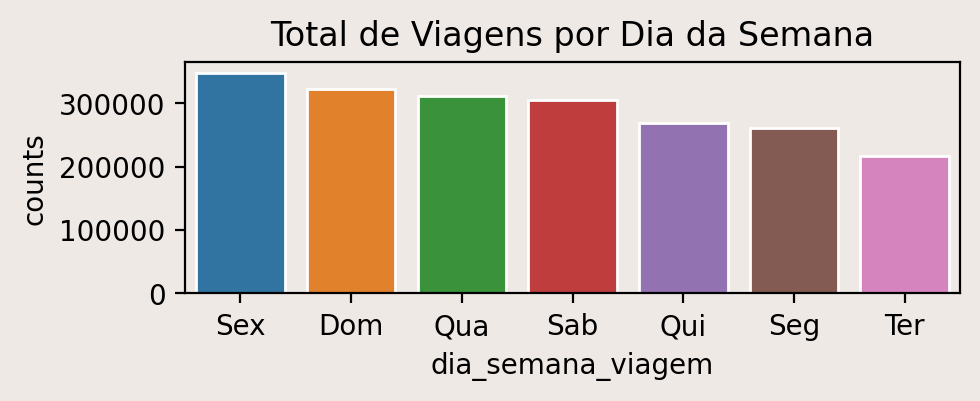

In [ ]:
fig = plt.figure(figsize=(5, 1.5), dpi = 200, facecolor = "#EFE9E6")
ax = plt.subplot(111, facecolor = "#EFE9E6")
temp_sem_viagem = value_counts_df(df5, 'dia_semana_viagem')
with sns.axes_style('white'):
    g = sns.barplot(x="dia_semana_viagem", y = 'counts', data=temp_sem_viagem)
    plt.title("Total de Viagens por Dia da Semana")
    plt.savefig("Fig1.png", bbox_inches='tight')

# Quais os top 10 destinos mais procurados?

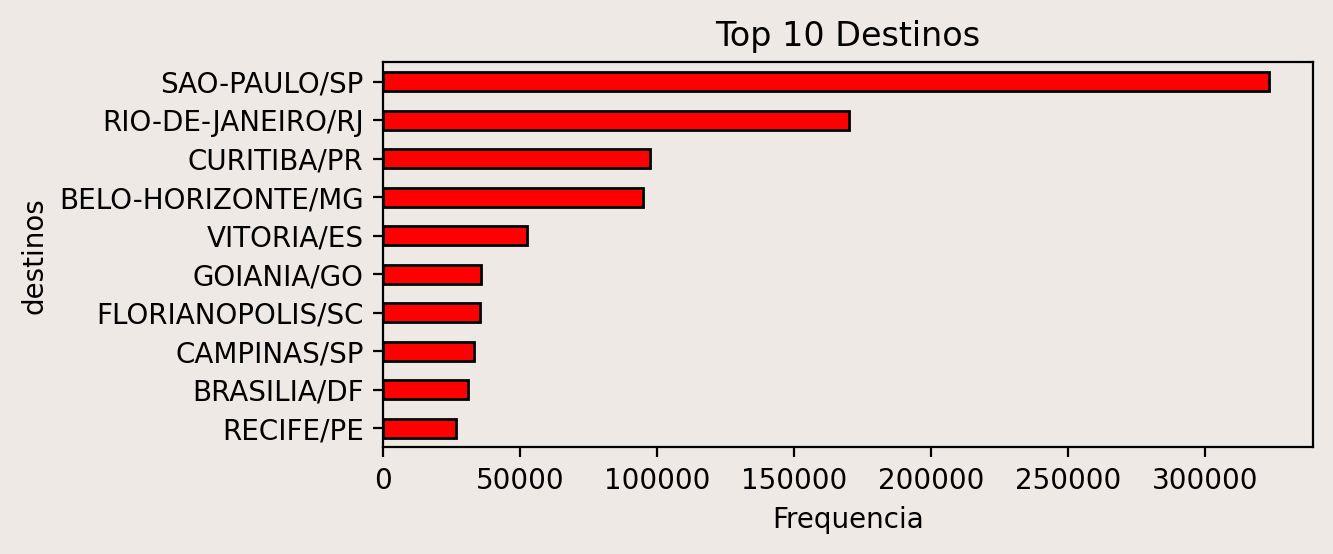

In [ ]:
fig = plt.figure(figsize=(6, 2.5), dpi = 200, facecolor = "#EFE9E6")
ax = plt.subplot(111, facecolor = "#EFE9E6")
top_10 = df5['ponto_destino_viagem'].value_counts().iloc[:10].sort_values(ascending=True)
top_10.plot.barh(edgecolor='black', color='red');
plt.xlabel('Frequencia')
plt.ylabel('destinos')
plt.title("Top 10 Destinos");
plt.savefig("Fig2.png", bbox_inches='tight')

# Qual o total de viagens por mês no dataset gerado?

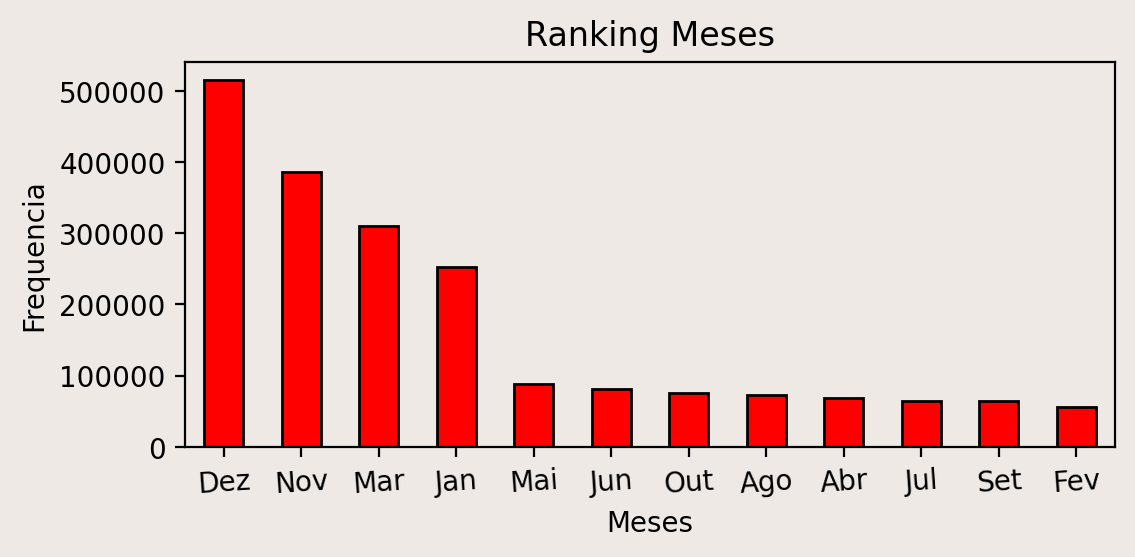

In [ ]:
fig = plt.figure(figsize=(6, 2.5), dpi = 200, facecolor = "#EFE9E6")
ax = plt.subplot(111, facecolor = "#EFE9E6")
ranking_meses= df5['mes_viagem'].value_counts()
#print("Total Viagens Mes\n",ranking_meses, '\n')
ranking_meses.plot(kind='bar', edgecolor='black', rot=4, color='red');
plt.xlabel('Meses')
plt.ylabel('Frequencia')
plt.title("Ranking Meses");
plt.savefig("Fig3.png", bbox_inches='tight')

# Total de Bilhetes Emitidos por Gratitude

In [ ]:
temp = df5['tipo_gratitude'].str.split('-', expand=True)
temp[0].value_counts()

Tarifa Normal                                   1441628
Tarifa Promocional                               441749
Bilhete de Viagem do Idoso 50%                    68665
Bilhete de Viagem do Idoso 100%                   26887
Gratuidade Jovem de Baixa Renda 100%              18326
Autorização de Viagem                             15626
Gratuidade Jovem de Baixa Renda 50%               12563
Gratuidade de Criança                              6778
Passe Livre Auditores e Agentes do Trabalho        1155
Name: 0, dtype: int64

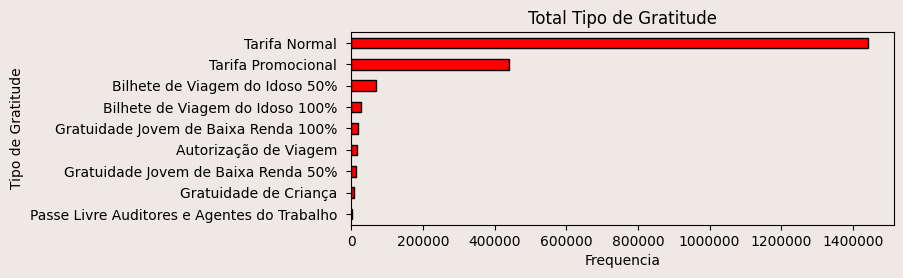

In [ ]:
fig = plt.figure(figsize=(7, 2.5), dpi = 100, facecolor = "#EFE9E6")
ax = plt.subplot(111, facecolor = "#EFE9E6")
temp = df5['tipo_gratitude'].str.split('-', expand=True)
gratitude_count = temp[0]
gratitude= gratitude_count.value_counts().sort_values(ascending=True)
#print("Total Tipos de Gratitude\n",gratitude, '\n')
gratitude.plot.barh(edgecolor='black', color='red');
plt.xlabel('Frequencia')
plt.ylabel('Tipo de Gratitude')
plt.title("Total Tipo de Gratitude");
plt.savefig("Fig4.png",  bbox_inches='tight') # do not permit cut text

# Total de Emissoes de Bilhetes por Dia

In [ ]:
temp = df5.copy()
#temp['data_emissao_bilhete'] = temp.data_emissao_bilhete.astype('object')
temp2 = temp['data_emissao_bilhete'].value_counts()
#
temp_data = []
for i in temp.data_emissao_bilhete:
  temp_data.append(rem_time(i))
#
temp = df5.copy()
temp['data_emissao_bilhete'] = temp_data


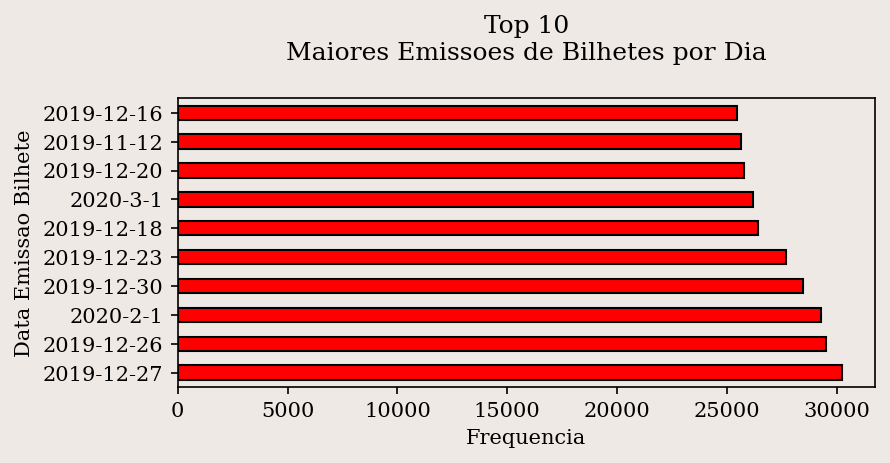

In [ ]:
fig = plt.figure(figsize=(6, 2.5), dpi = 150, facecolor = "#EFE9E6")
ax = plt.subplot(111, facecolor = "#EFE9E6")
temp2 = temp['data_emissao_bilhete'].value_counts().iloc[:10]
temp2
temp2.plot.barh(x= temp2.index , y=temp.values, edgecolor='black', color='red');
plt.xlabel('Frequencia')
plt.ylabel('Data Emissao Bilhete')
plt.title("Top 10\nMaiores Emissoes de Bilhetes por Dia\n");
plt.savefig("Fig5.png",  bbox_inches='tight')

# Qual o total de Passagens Vendidas entre UFs?

In [ ]:
df5[['origem_destino_linha','uf_origem_linha', 'uf_destino_linha']]

,origem_destino_linha,uf_origem_linha,uf_destino_linha
0,FLORIANOPOLIS(SC)-SAOPAULO(SP),SC,SP
1,FLORIANOPOLIS(SC)-CAMPINAS(SP),SC,SP
2,BALNEARIOCAMBORIU(SC)-SAOPAULO(SP),SC,SP
3,FLORIANOPOLIS(SC)-SAOPAULO(SP),SC,SP
4,BALNEARIOCAMBORIU(SC)-SAOPAULO(SP),SC,SP
...,...,...,...
999990,FORTALEZA(CE)-PARNAIBA(PI),CE,PI
999992,PONTENOVA(MG)-SAOPAULO(SP),MG,SP
999993,FORTALEZA(CE)-PARNAIBA(PI),CE,PI
999996,VITORIADACONQUISTA(BA)-CAMPINAS(SP),BA,SP


In [ ]:
df_uf = df5[['uf_origem_linha', 'uf_destino_linha']].value_counts().reset_index(name='count')
#
df_uf['ufs'] = df_uf.uf_origem_linha+'-->'+df_uf.uf_destino_linha

In [ ]:
df_uf.head()

,uf_origem_linha,uf_destino_linha,count,ufs
0,PR,SP,154065,PR-->SP
1,MG,RJ,134074,MG-->RJ
2,SP,MG,133341,SP-->MG
3,SP,RJ,127959,SP-->RJ
4,MG,SP,118747,MG-->SP


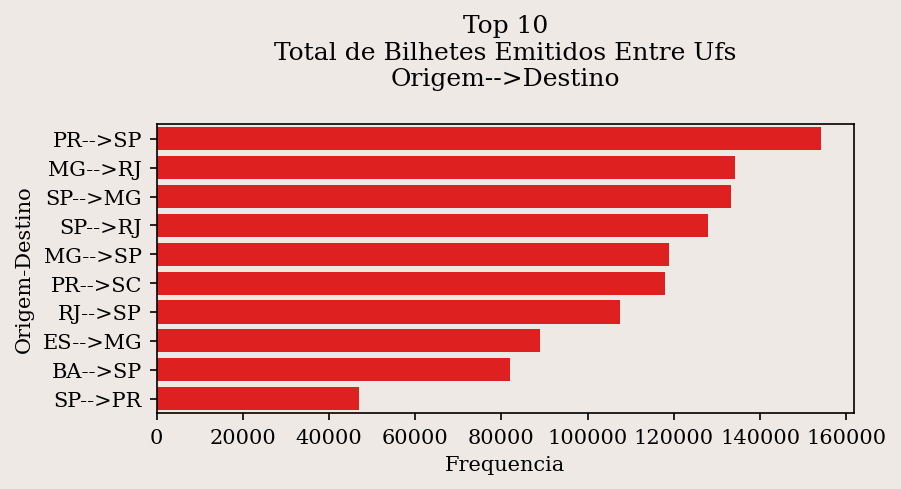

In [ ]:
fig = plt.figure(figsize=(6, 2.5), dpi = 150, facecolor = "#EFE9E6")
ax = plt.subplot(111, facecolor = "#EFE9E6")
temp = df_uf.iloc[:10]
#temp.plot.bar(x = 'ufs' , y= 'count', edgecolor='black', rot=80, color='red');
sns.barplot(x=temp['count'], y=temp['ufs'], orient='h', color='red')
plt.xlabel('Frequencia')
plt.ylabel('Origem-Destino')
plt.title("Top 10\nTotal de Bilhetes Emitidos Entre Ufs\nOrigem-->Destino\n");
plt.savefig("Fig6.png",  bbox_inches='tight')

# Fluxo de Viagens entre UFs
- https://python-graph-gallery.com/basic-sankey-diagram-with-pysankey/

In [ ]:
filter=10000
df_filtered = df_uf.loc[df_uf['count']>= filter].sort_values(by='count', ascending=False)
df_filtered.shape

(37, 4)

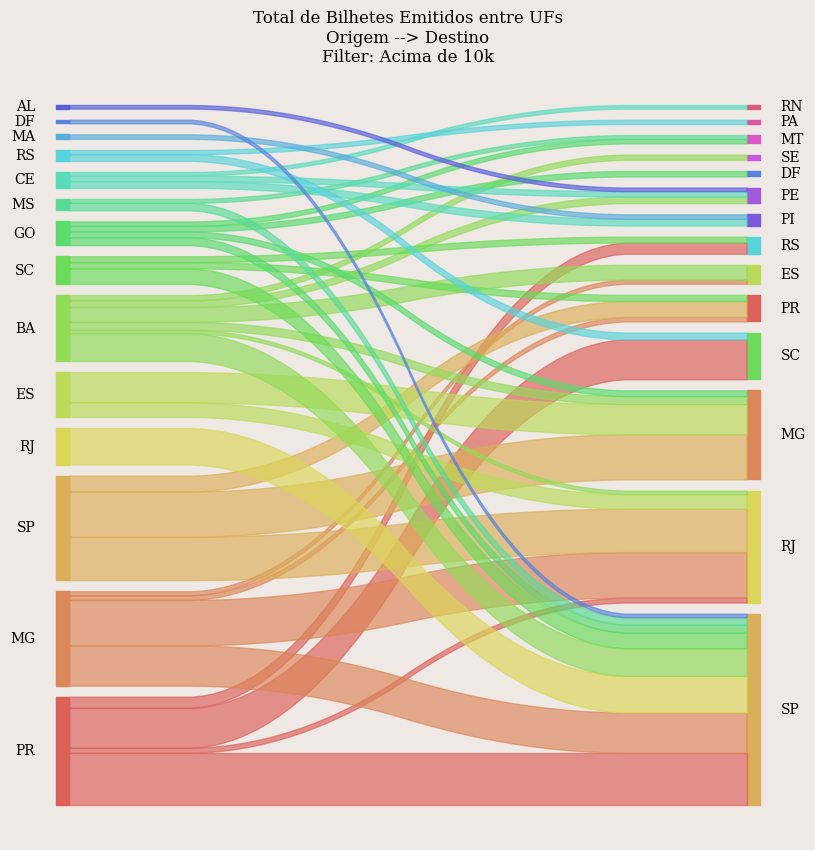

In [ ]:
sankey(
    left=df_filtered["uf_origem_linha"], right=df_filtered["uf_destino_linha"],
    leftWeight= df_filtered["count"], rightWeight=df_filtered["count"],
    aspect=20, fontsize=10
)

# Get current figure
fig = plt.gcf()



# Set size in inches
fig.set_size_inches(10, 10)

# Set the color of the background to white
fig.set_facecolor("#EFE9E6")
plt.title("Total de Bilhetes Emitidos entre UFs\nOrigem --> Destino\nFilter: Acima de 10k");
# Save the figure
plt.subplots_adjust(top=0.88)
fig.savefig("fluxo_passageiros.png", bbox_inches="tight", dpi=180)
plt.savefig("Fig7.png",  bbox_inches='tight')



In [ ]:
df5.columns

Index(['data_emissao_bilhete', 'categoria_transporte', 'origem_destino_linha',
       'ponto_origem_viagem', 'ponto_destino_viagem', 'tipo_servico',
       'data_viagem', 'tipo_viagem', 'numero_poltrona', 'tipo_gratitude',
       'valor_total', 'origem_linha', 'destino_linha', 'cidade_origem_linha',
       'uf_origem_linha', 'cidade_destino_linha', 'uf_destino_linha',
       'dia_emissao', 'mes_emissao', 'ano_emissao', 'dia_viagem',
       'mes_viagem_num', 'ano_viagem', 'mes_viagem', 'semana_num',
       'dia_semana_viagem', 'dif_days'],
      dtype='object')

In [ ]:
df_uf2 = df5[['uf_origem_linha', 'uf_destino_linha', 'mes_viagem']].value_counts().reset_index(name='count')
#
df_uf2['ufs_mes'] = df_uf2.uf_origem_linha+'-->'+df_uf2.uf_destino_linha+'-->'+df_uf2.mes_viagem

In [ ]:
df_uf2

,uf_origem_linha,uf_destino_linha,mes_viagem,count,ufs_mes
0,PR,SP,Dez,39062,PR-->SP-->Dez
1,MG,SP,Dez,33954,MG-->SP-->Dez
2,SP,RJ,Nov,33743,SP-->RJ-->Nov
3,MG,RJ,Dez,32175,MG-->RJ-->Dez
4,SP,MG,Mar,31302,SP-->MG-->Mar
...,...,...,...,...,...
2178,MS,TO,Jun,1,MS-->TO-->Jun
2179,ES,MT,Jun,1,ES-->MT-->Jun
2180,PA,TO,Set,1,PA-->TO-->Set
2181,CE,BA,Ago,1,CE-->BA-->Ago


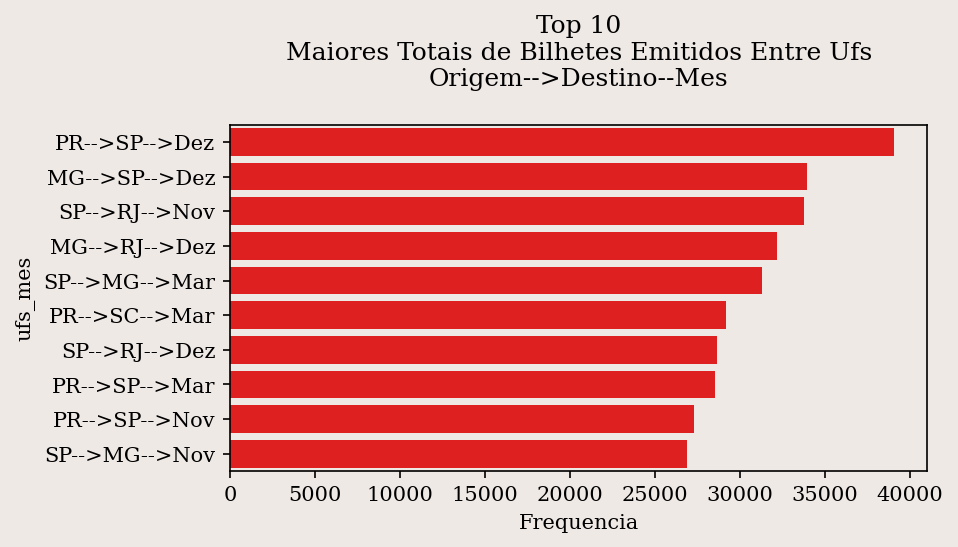

In [ ]:
fig = plt.figure(figsize=(6, 3.0), dpi = 150, facecolor = "#EFE9E6")
ax = plt.subplot(111, facecolor = "#EFE9E6")
temp = df_uf2.iloc[:10]
#temp.plot.bar(x = 'ufs_mes' , y= 'count', edgecolor='black', rot=45, color='red');
sns.barplot(x=temp['count'], y=temp['ufs_mes'], orient='h', color='red')
plt.xlabel('Frequencia')
plt.ylabel('ufs_mes')
plt.title("Top 10\nMaiores Totais de Bilhetes Emitidos Entre Ufs\nOrigem-->Destino--Mes\n");
plt.savefig("Fig8.png",  bbox_inches='tight')

In [ ]:
df_uf3 = df5[['uf_origem_linha', 'uf_destino_linha', 'dia_semana_viagem']].value_counts().reset_index(name='count')
#
df_uf3['ufs_dia'] = df_uf3.uf_origem_linha+'-->'+df_uf3.uf_destino_linha+'-->'+df_uf3.dia_semana_viagem

In [ ]:
df_uf3

,uf_origem_linha,uf_destino_linha,dia_semana_viagem,count,ufs_dia
0,PR,SP,Dom,26802,PR-->SP-->Dom
1,PR,SP,Sex,26081,PR-->SP-->Sex
2,PR,SP,Sab,25198,PR-->SP-->Sab
3,PR,SP,Qua,24364,PR-->SP-->Qua
4,SP,MG,Sex,24166,SP-->MG-->Sex
...,...,...,...,...,...
1333,PI,GO,Sex,1,PI-->GO-->Sex
1334,PI,DF,Qua,1,PI-->DF-->Qua
1335,PI,DF,Sab,1,PI-->DF-->Sab
1336,PI,DF,Seg,1,PI-->DF-->Seg


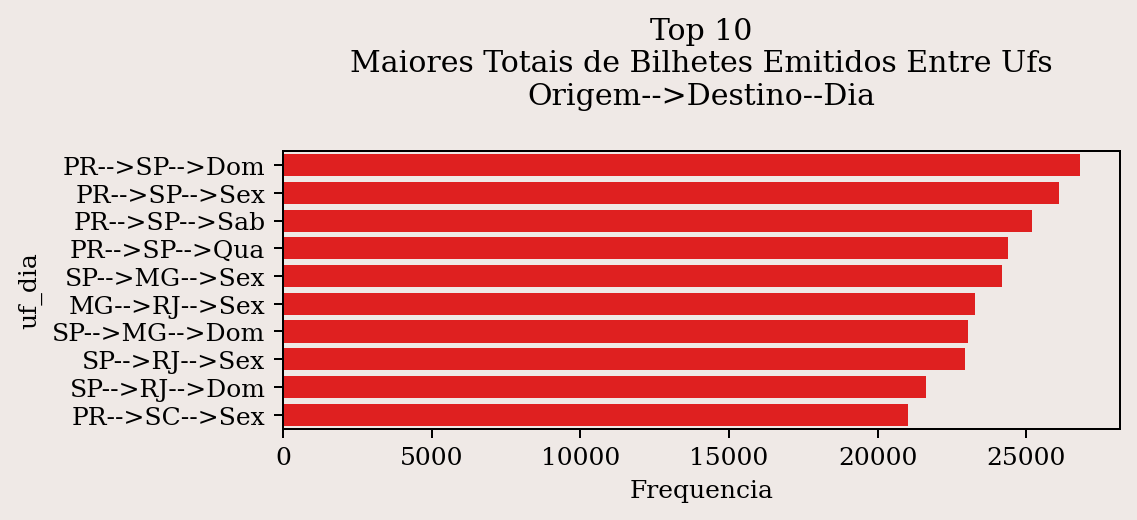

In [ ]:
fig = plt.figure(figsize=(6, 2.0), dpi = 180, facecolor = "#EFE9E6")
ax = plt.subplot(111, facecolor = "#EFE9E6")
temp = df_uf3.iloc[:10]
#temp.plot.bar(x = 'ufs_dia' , y= 'count', edgecolor='black', rot=45, color='red');
sns.barplot(x=temp['count'], y=temp['ufs_dia'], orient='h', color='red')
plt.xlabel('Frequencia')
plt.ylabel('uf_dia')
plt.title("Top 10\nMaiores Totais de Bilhetes Emitidos Entre Ufs\nOrigem-->Destino--Dia\n");
plt.savefig("Fig9.png",  bbox_inches='tight')

In [ ]:
#df_bilhete= value_counts_df(df5, 'data_emissao_bilhete')

In [ ]:
temp = df5.copy()

In [ ]:
temp2 = temp.groupby(['uf_origem_linha', 'uf_destino_linha']).value_counts().reset_index(name='counts')


In [ ]:
temp2[['uf_origem_linha', 'uf_destino_linha', 'counts']].sort_values(by='counts', ascending=False)

,uf_origem_linha,uf_destino_linha,counts
922637,PR,RJ,34
590497,MG,RJ,22
1064335,PR,SP,20
709428,MG,SP,18
1617446,SP,RJ,16
...,...,...,...
637225,MG,RJ,1
637224,MG,RJ,1
637223,MG,RJ,1
637222,MG,RJ,1


In [ ]:
df5[['uf_origem_linha', 'uf_destino_linha']].value_counts().reset_index(name='counts')


,uf_origem_linha,uf_destino_linha,counts
0,PR,SP,154065
1,MG,RJ,134074
2,SP,MG,133341
3,SP,RJ,127959
4,MG,SP,118747
...,...,...,...
199,PI,DF,5
200,SC,RO,3
201,PR,AC,1
202,PI,MA,1


In [ ]:
df_count1 = df5[['origem_destino_linha', 'ponto_destino_viagem']].value_counts().reset_index(name='counts')

In [ ]:
df_count1

,origem_destino_linha,ponto_destino_viagem,counts
0,SAOPAULO(SP)-RIODEJANEIRO(RJ),SAO-PAULO/SP,59752
1,SAOPAULO(SP)-RIODEJANEIRO(RJ),RIO-DE-JANEIRO/RJ,53609
2,SAOPAULO(SP)-BELOHORIZONTE(MG),SAO-PAULO/SP,27172
3,SAOPAULO(SP)-BELOHORIZONTE(MG),BELO-HORIZONTE/MG,24777
4,CURITIBA(PR)-FLORIANOPOLIS(SC),CURITIBA/PR,20033
...,...,...,...
9197,CORNELIOPROCOPIO(PR)-ASSIS(SP),TARUMA/SP,1
9198,LONDRINA(PR)-SAOJOSEDORIOPRETO(SP),MARTINOPOLIS/SP,1
9199,SAOPAULO(SP)-RIODEJANEIRO(RJ),FORQUETINHA/RS,1
9200,CORNELIOPROCOPIO(PR)-ASSIS(SP),FLORINEA/SP,1


In [ ]:
temp1 = df5.loc[df5.origem_destino_linha=='SAOPAULO(SP)-RIODEJANEIRO(RJ)']
temp1.loc[temp1.ponto_destino_viagem == 'SAO-PAULO/SP']

,data_emissao_bilhete,categoria_transporte,origem_destino_linha,ponto_origem_viagem,ponto_destino_viagem,tipo_servico,data_viagem,tipo_viagem,numero_poltrona,tipo_gratitude,...,dia_emissao,mes_emissao,ano_emissao,dia_viagem,mes_viagem_num,ano_viagem,mes_viagem,semana_num,dia_semana_viagem,dif_days
23,2019-03-29,Interestadual,SAOPAULO(SP)-RIODEJANEIRO(RJ),RIO DE JANEIRO/RJ,SAO-PAULO/SP,Convencional com sanitário,2019-03-31,Regular,4,Tarifa Normal - sem desconto,...,29,3,2019,31,3,2019,Mar,0,Dom,2
25,2019-03-20,Interestadual,SAOPAULO(SP)-RIODEJANEIRO(RJ),RIO DE JANEIRO/RJ,SAO-PAULO/SP,Convencional com sanitário,2019-03-22,Regular,45,Tarifa Normal - sem desconto,...,20,3,2019,22,3,2019,Mar,5,Sex,2
27,2019-01-14,Interestadual,SAOPAULO(SP)-RIODEJANEIRO(RJ),RIO DE JANEIRO/RJ,SAO-PAULO/SP,Convencional com sanitário,2019-05-03,Regular,7,Tarifa Normal - sem desconto,...,14,1,2019,3,5,2019,Mai,5,Sex,109
28,2019-03-18,Interestadual,SAOPAULO(SP)-RIODEJANEIRO(RJ),RIO DE JANEIRO/RJ,SAO-PAULO/SP,Convencional com sanitário,2019-03-22,Regular,19,Tarifa Normal - sem desconto,...,18,3,2019,22,3,2019,Mar,5,Sex,4
29,2019-03-20,Interestadual,SAOPAULO(SP)-RIODEJANEIRO(RJ),RIO DE JANEIRO/RJ,SAO-PAULO/SP,Convencional com sanitário,2019-03-24,Regular,27,Tarifa Normal - sem desconto,...,20,3,2019,24,3,2019,Mar,0,Dom,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999931,2019-12-27,Interestadual,SAOPAULO(SP)-RIODEJANEIRO(RJ),RIO DE JANEIRO/RJ,SAO-PAULO/SP,Semileito,2020-01-01,Regular,11,Tarifa Normal - sem desconto,...,27,12,2019,1,1,2020,Jan,3,Qua,5
999932,2020-02-01,Interestadual,SAOPAULO(SP)-RIODEJANEIRO(RJ),RIO DE JANEIRO/RJ,SAO-PAULO/SP,Semileito,2020-05-01,Regular,6,Tarifa Normal - sem desconto,...,1,2,2020,1,5,2020,Mai,5,Sex,90
999934,2019-12-30,Interestadual,SAOPAULO(SP)-RIODEJANEIRO(RJ),RIO DE JANEIRO/RJ,SAO-PAULO/SP,Semileito,2020-01-01,Regular,45,Tarifa Normal - sem desconto,...,30,12,2019,1,1,2020,Jan,3,Qua,2
999935,2020-04-01,Interestadual,SAOPAULO(SP)-RIODEJANEIRO(RJ),RIO DE JANEIRO/RJ,SAO-PAULO/SP,Executivo,2020-06-01,Regular,47,Tarifa Normal - sem desconto,...,1,4,2020,1,6,2020,Jun,1,Seg,61


In [ ]:
df5.columns

Index(['data_emissao_bilhete', 'categoria_transporte', 'origem_destino_linha',
       'ponto_origem_viagem', 'ponto_destino_viagem', 'tipo_servico',
       'data_viagem', 'tipo_viagem', 'numero_poltrona', 'tipo_gratitude',
       'valor_total', 'origem_linha', 'destino_linha', 'cidade_origem_linha',
       'uf_origem_linha', 'cidade_destino_linha', 'uf_destino_linha',
       'dia_emissao', 'mes_emissao', 'ano_emissao', 'dia_viagem',
       'mes_viagem_num', 'ano_viagem', 'mes_viagem', 'semana_num',
       'dia_semana_viagem', 'dif_days'],
      dtype='object')

# Gasto Médio, Min e Max com Bilhete por UF
- tabela: https://www.scaler.com/topics/matplotlib/matplotlib-table/

In [ ]:
df5.columns

Index(['data_emissao_bilhete', 'categoria_transporte', 'origem_destino_linha',
       'ponto_origem_viagem', 'ponto_destino_viagem', 'tipo_servico',
       'data_viagem', 'tipo_viagem', 'numero_poltrona', 'tipo_gratitude',
       'valor_total', 'origem_linha', 'destino_linha', 'cidade_origem_linha',
       'uf_origem_linha', 'cidade_destino_linha', 'uf_destino_linha',
       'dia_emissao', 'mes_emissao', 'ano_emissao', 'dia_viagem',
       'mes_viagem_num', 'ano_viagem', 'mes_viagem', 'semana_num',
       'dia_semana_viagem', 'dif_days'],
      dtype='object')

In [ ]:
df5.groupby(['origem_destino_linha'])['valor_total'].agg(['count','sum', 'mean', 'min', 'max'])

,count,sum,mean,min,max
origem_destino_linha,,,,,
AGUABOA(MG)-SAOPAULO(SP),3281,385882.656250,117.611298,0.0,269.000000
AGUASDAPRATA(SP)-POCOSDECALDAS(MG),10067,64062.839844,6.363647,0.0,11.990000
ALEMPARAIBA(MG)-JUIZDEFORA(MG),1945,47805.230469,24.578526,0.0,34.869999
ALEMPARAIBA(MG)-SAOFIDELIS(RJ),127,1551.219971,12.214331,0.0,27.209999
ALFENAS(MG)-RIODEJANEIRO(RJ),1737,199442.125000,114.819878,0.0,205.000000
...,...,...,...,...,...
VOLTAREDONDA(RJ)-SAOPAULO(SP),10381,953127.187500,91.814583,0.0,189.990005
WENCESLAUBRAZ(PR)-ITAPORANGA(SP),643,7395.410156,11.501415,0.0,15.300000
WENCESLAUBRAZ(PR)-SAOPAULO(SP),109,5260.479980,48.261284,0.0,105.570000


In [ ]:
import numpy as np

In [ ]:
temp_agg = df5.copy()
temp_agg['count'] = temp_agg.groupby('origem_destino_linha')['valor_total'].transform('count')
temp_agg['sum'] = np.round(temp_agg.groupby('origem_destino_linha')['valor_total'].transform('sum'),2)
temp_agg['mean'] = np.round(temp_agg.groupby('origem_destino_linha')['valor_total'].transform('mean'),2)
temp_agg['max'] = np.round(temp_agg.groupby('origem_destino_linha')['valor_total'].transform('max'),2)
temp_agg['min'] = np.round(temp_agg.groupby('origem_destino_linha')['valor_total'].transform('min'),2)
temp_agg = temp_agg[['origem_destino_linha','count', 'sum', 'mean', 'max', 'min']]
#
temp_agg.origem_destino_linha = temp_agg.origem_destino_linha.str.replace('-', ' --> ')

In [ ]:
temp_agg.drop_duplicates(inplace=True)
temp_agg = temp_agg.sort_values(by='count', ascending=False)

In [ ]:
temp_agg

,origem_destino_linha,count,sum,mean,max,min
23,SAOPAULO(SP) --> RIODEJANEIRO(RJ),115290,1.294352e+07,112.269997,455.739990,0.0
64,SAOPAULO(SP) --> BELOHORIZONTE(MG),52832,7.050128e+06,133.440002,350.190002,0.0
80,CURITIBA(PR) --> FLORIANOPOLIS(SC),48929,2.797479e+06,57.169998,129.990005,0.0
249,SAOPAULO(SP) --> CURITIBA(PR),39018,4.212577e+06,107.959999,329.989990,0.0
436,BELOHORIZONTE(MG) --> RIODEJANEIRO(RJ),34059,3.955690e+06,116.139999,319.989990,0.0
432954,VITORIA(ES) --> RIODEJANEIRO(RJ),24389,2.862380e+06,117.360001,515.419983,0.0
627,MARINGA(PR) --> SAOPAULO(SP),21686,2.479004e+06,114.309998,237.160004,0.0
771,LONDRINA(PR) --> SAOPAULO(SP),18318,1.838186e+06,100.349998,278.790009,0.0
245,PIRAPETINGA(MG) --> RIODEJANEIRO(RJ),17796,9.739426e+05,54.730000,122.470001,0.0
109,PIRAPETINGA(MG) --> ITAPERUNA(RJ),15336,2.906882e+05,18.950001,56.150002,0.0


In [ ]:
#df_viagem.loc[df_viagem['valor_total'] == 0.00]['tipo_gratitude']

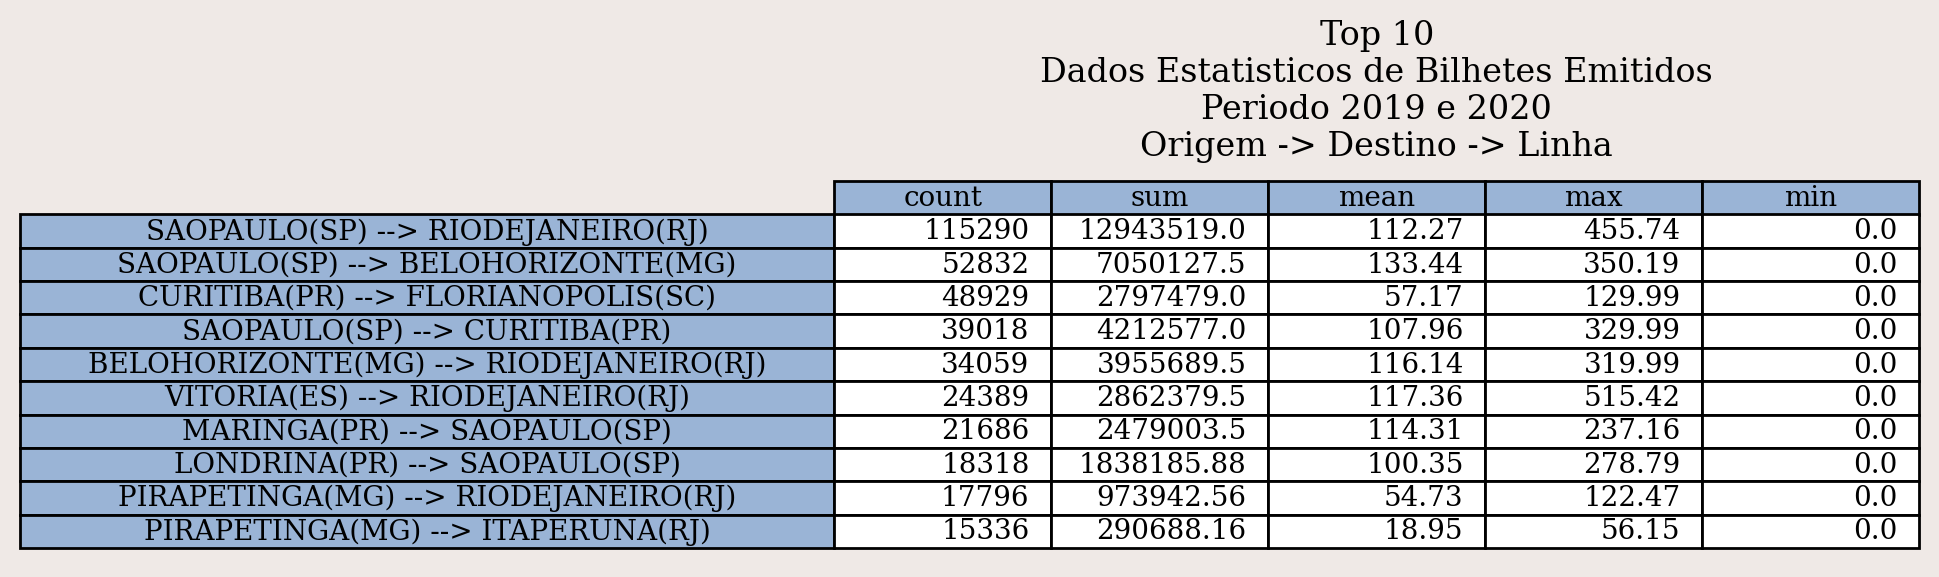

In [ ]:
fig = plt.figure(figsize=(7, 2.5), dpi = 200, facecolor = "#EFE9E6")
ax = plt.subplot(111, facecolor = "#EFE9E6")

temp_agg = temp_agg[:10]
msg = 'Top 10\nDados Estatisticos de Bilhetes Emitidos\nPeriodo 2019 e 2020\nOrigem -> Destino -> Linha'

title_text = msg

plt.title(title_text)

fig_background_color = 'grey'
#fig_border = 'skyblue'
headers = temp_agg.columns.to_list()[1:]
#print('headers', headers)
values = temp_agg[['sum', 'mean','max', 'min']].values.tolist()
value_count = temp_agg[ 'count'].values.tolist()
# coluna count deve ser inteira e as demais são decimais ou float
for i in range(len(value_count)):
  values[i].insert(0,value_count[i])

#the headers from the data array
column_headers = headers
row_headers = [x for x in temp_agg.origem_destino_linha.tolist()]

#print('row headers',row_headers)
cell_text = []
for row in values:
    #print('row',row)
    cell_text.append([np.round(x,2) for x in row])

#print('cell_text',cell_text)
rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.4))
ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.4))

#Creating the figure. Setting a small pad on the tight layout

# plt.figure(linewidth=2,
#            edgecolor=fig_border,
#            facecolor = "#EFE9E6",
#            tight_layout={'pad':1})

#Adding a table at the bottom of the axes

the_table = plt.table(cellText=cell_text,
                      rowLabels=row_headers,
                      rowColours=rcolors,
                      rowLoc='center',
                      colColours=ccolors,
                      colLabels=column_headers,
                      loc='center')

# Scaling influences the top and bottom cell padding.
#the_table.scale(2.0, 3.5)

# Hiding axes
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Hiding axes border
plt.box(on=None)



# Without plt.draw() here, the title will center on the axes and not the figure.
#plt.draw()

# Creating the image. plt.savefig ignores the edge and face colors, so we need to map them.
fig = plt.gcf()
plt.savefig('pyplot-table-demo.png',
            bbox_inches='tight',
            edgecolor=fig.get_edgecolor(),
            facecolor=fig.get_facecolor(),
            dpi=200
            )
plt.savefig("Fig10.png",  bbox_inches='tight')

# Total de Bilhetes Emitidos por UF no periodo de 2019 e 2020.

In [ ]:
temp = df_uf.copy()
temp['total_uf_orig'] = df_uf.groupby('uf_origem_linha')['count'].transform('sum')


In [ ]:
temp_uf_total = temp[['uf_origem_linha', 'total_uf_orig']].drop_duplicates().sort_values(by='total_uf_orig', ascending=False)

In [ ]:
temp_top10 = temp_uf_total[:10]

In [ ]:
lista_uf = temp_top10.uf_origem_linha.values
lista_uf

array(['SP', 'PR', 'MG', 'BA', 'ES', 'RJ', 'GO', 'SC', 'CE', 'RS'],
      dtype=object)

In [ ]:
X= temp_top10['total_uf_orig'].values
X

array([324287, 322878, 306811, 211043, 141281, 130760, 106579,  93609,
        76655,  56835])

In [ ]:
height = temp_top10['total_uf_orig'].reset_index(drop=True)

In [ ]:
rj = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_Rio_de_Janeiro.png')
ba = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_da_Bahia.png')
pb = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_da_Paraíba.png')
al = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_de_Alagoas.png')
#
go = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_de_Goiás.png')
mg = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_de_Minas_Gerais.png')
pe = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_de_Pernambuco.png')
ro = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_de_Rondônia.png')
#
rr = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_de_Roraima.png')
sc = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_de_Santa_Catarina.png')
se = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_de_Sergipe.png')
ac = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Acre.png')
#
ap = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Amapa.png')
am = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Amazonas.png')
ce = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Ceara.png')
df = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Distrito_Federal_Brasil.png')
#
es = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Espírito_Santo.png')
ma = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Maranhao.png')
pa = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Para.png')
pr = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Parana.png')
#
pi = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Piaui.png')
rn = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Rio_Grande_do_Norte.png')
rs = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Rio_Grande_do_Sul.png')
to = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Tocantins.png')
#
sp = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_Sao_Paulo.png')
ms = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_Mato_Grosso_do_Sul.png')
mt = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_de_Mato_Grosso.png')


In [ ]:
dict_icons = {'RJ':rj, 'BA':ba, 'PB':pb, 'AL':al, 'GO':go, 'MG':mg, 'PE':pe, 'RO': ro, 'RR':rr, 'SC': sc, 'SE': se, 'AC':ac, 'AP':ap, 'AM': am, 'CE':ce, 'DF':df,
              'ES': es, 'MA':ma, 'PA': pa, 'PR': pr, 'PI':pi, 'RN': rn, 'RS': rs, 'TO':to, 'SP':sp, 'MS':ms, 'MT':mt}

In [ ]:
X = np.arange(len(height))
X

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
temp_top10["uf_origem_linha"]

2     SP
0     PR
1     MG
8     BA
7     ES
6     RJ
15    GO
10    SC
17    CE
18    RS
Name: uf_origem_linha, dtype: object

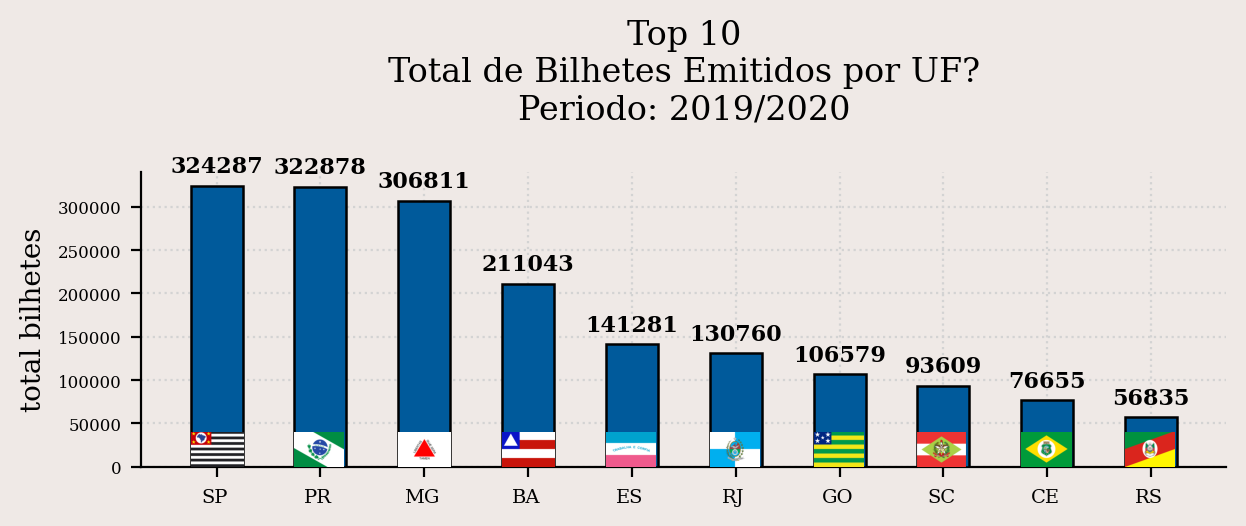

In [ ]:
fig = plt.figure(figsize=(7, 2.5), dpi = 200, facecolor = "#EFE9E6")
ax = plt.subplot(111, facecolor = "#EFE9E6")

plt.ylabel("total bilhetes")
#plt.xlabel("uf")
plt.title("Top 10\nTotal de Bilhetes Emitidos por UF?\nPeriodo: 2019/2020\n")


# Add spines
ax.spines["top"].set(visible = False)
ax.spines["right"].set(visible = False)

# Add grid and axis labels
ax.grid(True, color = "lightgrey", ls = ":")

# We specify the width of the bar
width = 0.5

# Fouls conceded
ax.bar(
    X,
    height,
    ec = "black",
    lw = .9,
    color = "#005a9b",
    zorder = 3,
    width = width
)

for index, y in enumerate(height):
    ax.annotate(
        xy = (index, y),
        text = f"{y}",
        xytext = (0, 7),
        textcoords = "offset points",
        size = 8,
        color = "black",# "#005a9b",
        ha = "center",
        va = "center",
        weight = "bold"
    )

xticks_ = ax.xaxis.set_ticks(
    ticks = X,
    labels = []
)

ax.tick_params(labelsize = 6)


# --- Axes transformations

DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform

# Native data to normalized data coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

for index, uf in enumerate(temp_top10["uf_origem_linha"]):
    ax_coords = DC_to_NFC([index - width/2, -0.005])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.07, 0.07], anchor = "W")
    uf_icon = dict_icons.get(uf)
    logo_ax.imshow(uf_icon)
    logo_ax.axis("off")

    logo_ax.annotate(
        xy =(0, 0),
        text = f"{temp_uf_total['uf_origem_linha'].iloc[index]}",
        xytext = (8.5, -23.5), # (x,y) x é a posicao relativa ao eixo vertical e y eixo horizontal onde aparece o icone da UF
        textcoords = "offset points",
        size = 7,
        ha = "center",
        va = "center"
    )

# fig_text(
#     x = 0.12, y = 1.2,
#     s = "Top 10 - Total de Bilhete Emitidos por UF?",
#     weight = "bold",
#     size = 10
# )

# fig_text(
#     x = 0.12, y = 1.1,
#     s = "Periodo: 2019/2020",
#     color = "grey",
#     size = 8
# )
#plt.tight_layout()
plt.subplots_adjust(top=0.70)
plt.savefig("\nTop10_Total_Bilhetes_por_UF.png")
plt.savefig("Fig11.png", bbox_inches='tight')
plt.show()

# INICIAR ANALISE

![](https://drive.google.com/uc?export=view&id=1uRhFT-YkC2B2VHM9FAi-U5Sofkdu7zNU)


# **Análises com base nos gráficos gerados**

 

	Ouarta-feira ficou atrás de sexta-feira e domingo. Feriados ocorrridos na quinta-feira emendando com a sexta-feira 
através de banco de horas, pode ser uma explicação.



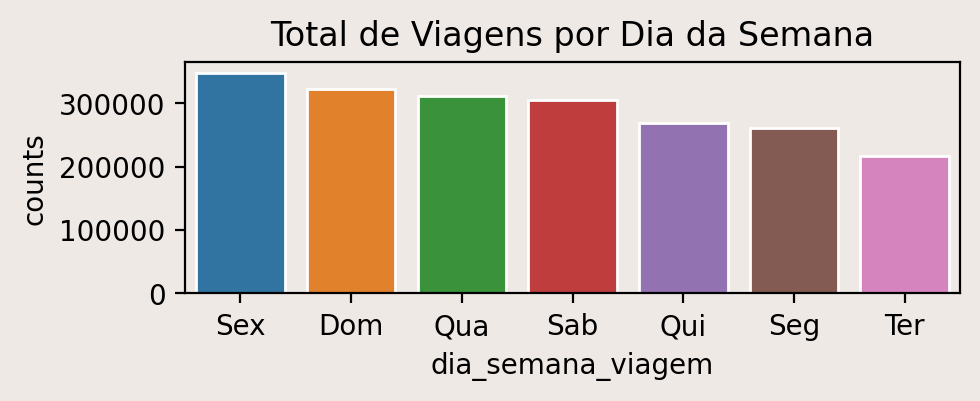

In [ ]:
# Fig1
print('\033[1m',"\n\n\tOuarta-feira ficou atrás de sexta-feira e domingo. Feriados ocorrridos na quinta-feira emendando com a sexta-feira \natravés de banco de horas, pode ser uma explicação.\n")
fig = Image.open('/content/Fig1.png')
fig.show()

 

	A cidade de Campinas no Estado de São Paulo destaca-se entre as mais visitadas, as demais são todas capitais e o distrito federal.
	Na região de Campinas se localizam a Unicamp, centros de pesquisas como o CPQD e grandes empresas tais como a IBM e EMS.



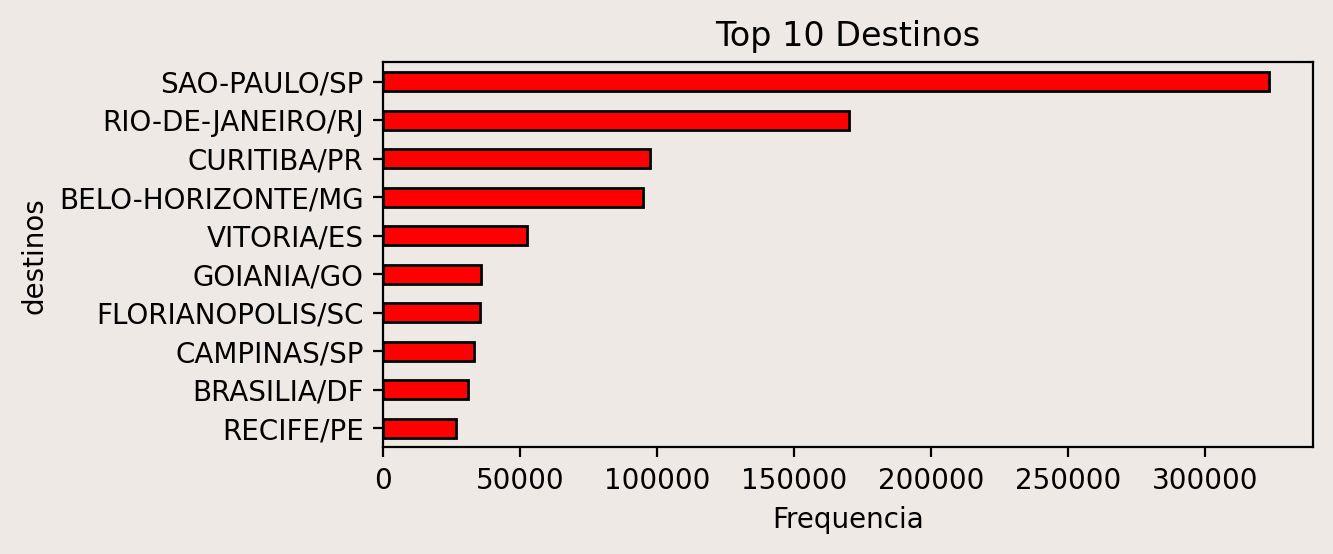

In [ ]:
# Fig2
print('\033[1m',"\n\n\tA cidade de Campinas no Estado de São Paulo destaca-se entre as mais visitadas, as demais são todas capitais e o distrito federal.\n\tNa região de Campinas se localizam a Unicamp, centros de pesquisas como o CPQD e grandes empresas tais como a IBM e EMS.\n")
fig = Image.open('/content/Fig2.png')
fig.show()

 

	Na base de dados o ano de 2020 representa 28%, sendo um ano marcado pelas restrições de deslocamento devido a pandemia do Covid.
	Os meses de Dezembro, Novembro e Março mostram os valores relativos a 2019, pois não haviam restrições ainda.




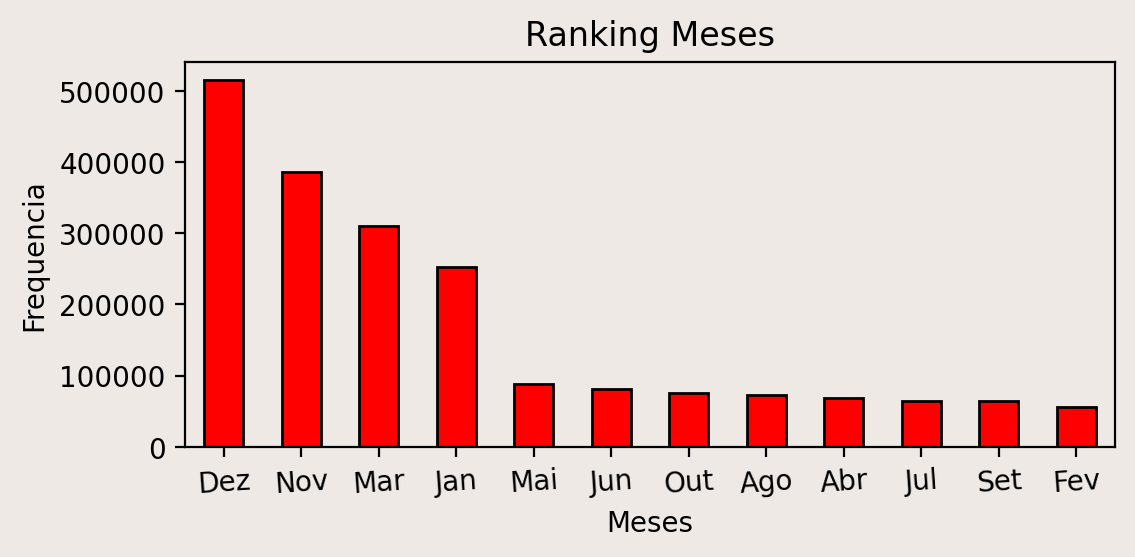

In [ ]:
# Fig3
#print(df5['ano_viagem'].value_counts(normalize=True))
"""
2019    0.720453
2020    0.279547
Name: ano_viagem, dtype: float64
"""
print('\033[1m',"\n\n\tNa base de dados o ano de 2020 representa 28%, sendo um ano marcado pelas restrições de deslocamento devido a pandemia do Covid.\n\tOs meses de Dezembro, Novembro e Março mostram os valores relativos a 2019, pois não haviam restrições ainda.\n\n")
fig = Image.open('/content/Fig3.png')
fig.show()

 

	A tarifa normal, sem desconto representa 70% e o restante corresponde ao uso de algum beneficio social ou promoção.



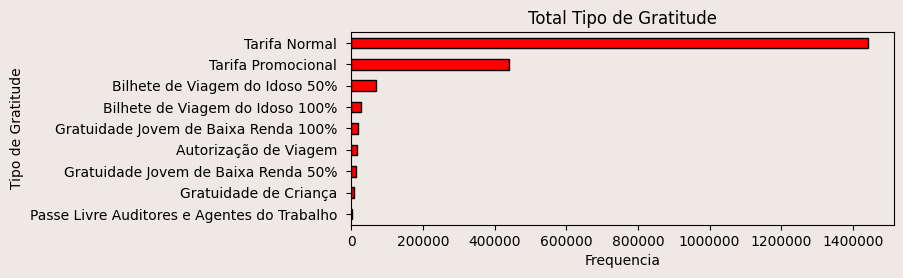

In [ ]:
# Fig4
#print(df5['tipo_gratitude'].value_counts(normalize=True))
"""
Tarifa Normal - sem desconto                                                     0.708986
Tarifa Promocional - Parágrafo 3º, art. 27 do Decreto nº 2.521/98                0.217253
Bilhete de Viagem do Idoso 50% - Inciso II, art. 40 da Lei nº 10.741/03          0.033761
Bilhete de Viagem do Idoso 100% - Inciso I, art. 40 da Lei nº 10.741/03          0.013223
Gratuidade Jovem de Baixa Renda 100% - Inciso I, art. 32 da Lei nº 12.852/13     0.009013
Autorização de Viagem - Passe Livre - Art. 1º da Lei nº 8.899/94                 0.007683
Gratuidade Jovem de Baixa Renda 50% - Inciso II, art. 32 da Lei nº 12.852/13     0.006179
Gratuidade de Criança - Inciso XVII, art. 29 do Decreto nº 2.521/98              0.003333
Passe Livre Auditores e Agentes do Trabalho - Art. 34 do Decreto nº 4.552/02     0.000568
Autorização de Viagem - Passe Livre Acompanhante - Art. 1º da Lei nº 8.899/94    0.000001
Name: tipo_gratitude, dtype: float64
"""
print('\033[1m',"\n\n\tA tarifa normal, sem desconto representa 70% e o restante corresponde ao uso de algum beneficio social ou promoção.\n")
fig = Image.open('/content/Fig4.png')
fig.show()

 

	Natal e ano novo são os maiores responsáveis por bilhetes emitidos, provavelmente comprados com antecedência devido ao grande fluxo no periodo.




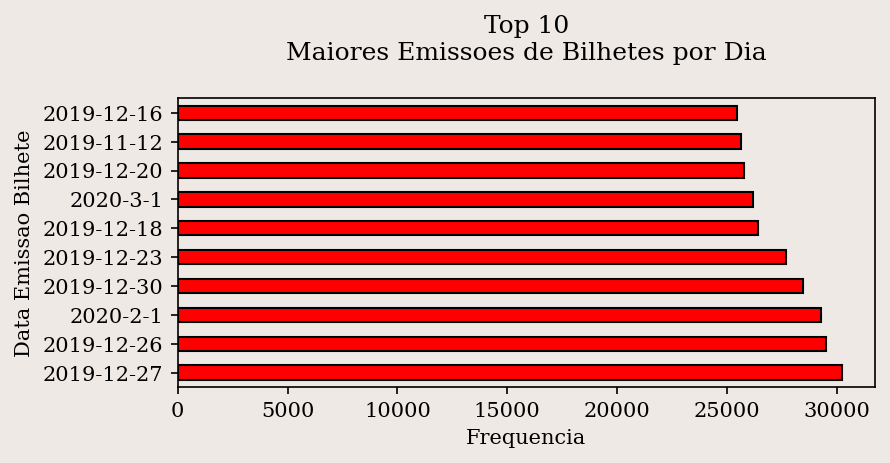

In [ ]:
# Fig5
print('\033[1m',"\n\n\tNatal e ano novo são os maiores responsáveis por bilhetes emitidos, provavelmente comprados com antecedência devido ao grande fluxo no periodo.\n\n")
fig = Image.open('/content/Fig5.png')
fig.show()

 

	O Estado de São Paulo esta presente como destino, em 4 dos 10 Top maiores volumes de bilhetes emitidos.
	O que indica ser um ponto de atração para diversas pessoas.
	Que visitam por motivo de trabalho, familiar ou a passeio.




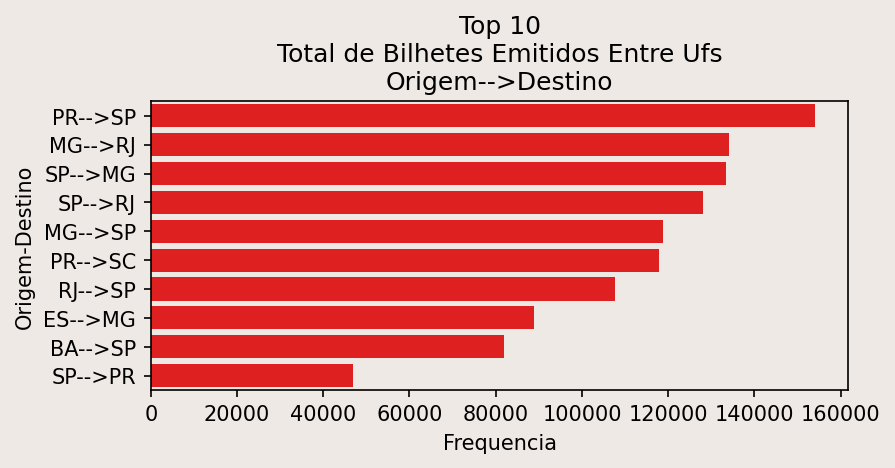

In [ ]:
# Fig6
print('\033[1m',"\n\n\tO Estado de São Paulo esta presente como destino, em 4 dos 10 Top maiores volumes de bilhetes emitidos.\n\tO que indica ser um ponto de atração para diversas pessoas.\n\tQue visitam por motivo de trabalho, familiar ou a passeio.\n\n")
fig = Image.open('/content/Fig6.png')
fig.show()

In [ ]:
#df_uf.loc[df_uf['count']>= filter].sort_values(by='count', ascending=False)[['uf_origem_linha', 'uf_destino_linha', 'count']].head()

 

	Os maiores fluxos de pessoas viajando saem do Paraná, São Paulo, Minas Gerais, Rio de Janeiro, Espirito Santo e Bahia.




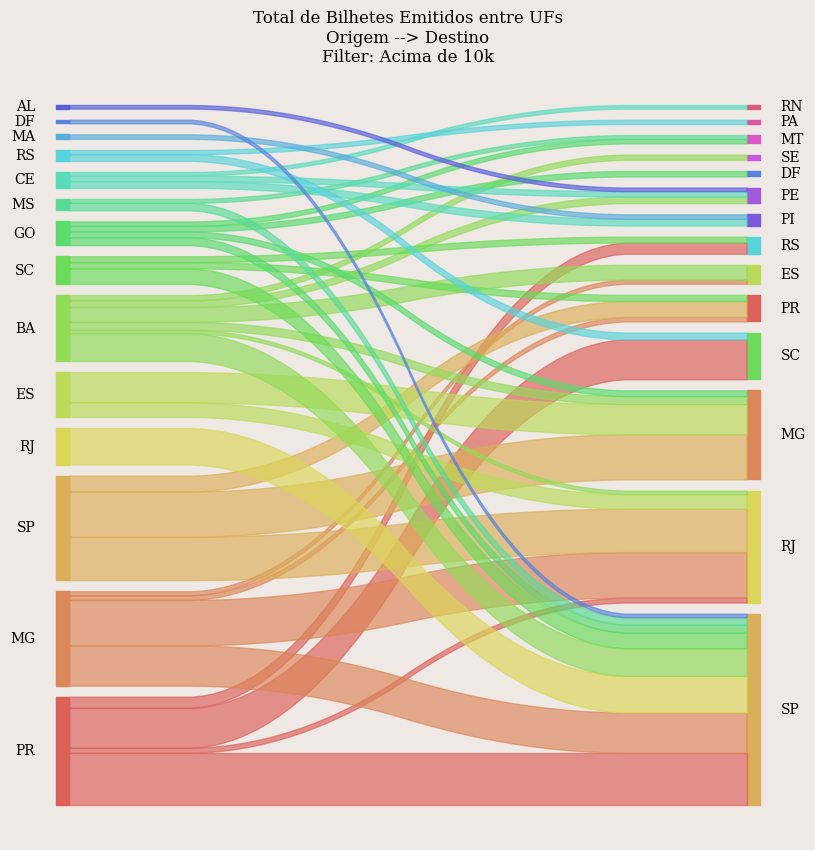

In [ ]:
# Fig7
# df_uf.loc[df_uf['count']>= filter].sort_values(by='count', ascending=False)[['uf_origem_linha', 'uf_destino_linha', 'count']]
"""
	uf_origem_linha	uf_destino_linha	count
0	PR	SP	154065
1	MG	RJ	134074
2	SP	MG	133341
3	SP	RJ	127959
-
-
-
35	AL	PE	10547
36	BA	RJ	10502
"""
print('\033[1m',"\n\n\tOs maiores fluxos de pessoas viajando saem do Paraná, São Paulo, Minas Gerais, Rio de Janeiro, Espirito Santo e Bahia.\n\n")
fig = Image.open('/content/Fig7.png')
fig.show()

 

	No mês de Março de 2019 ocorreu o carnaval e provavelmente muitas pessoas viajaram.
	Em 2020 haviam restrições devido ao Covid.




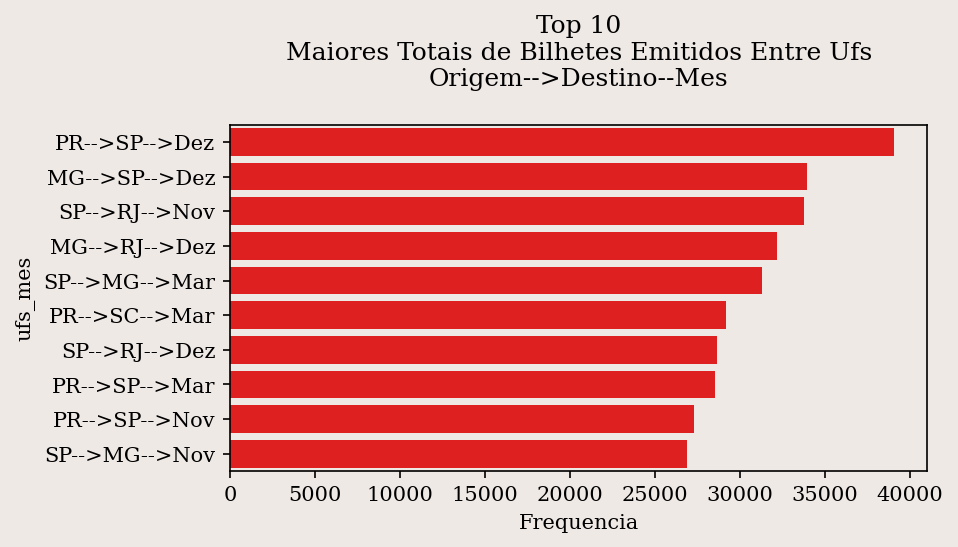

In [ ]:
# Fig8
print('\033[1m',"\n\n\tNo mês de Março de 2019 ocorreu o carnaval e provavelmente muitas pessoas viajaram.\n\tEm 2020 haviam restrições devido ao Covid.\n\n")
fig = Image.open('/content/Fig8.png')
fig.show()

 

	Os Estados do Paraná e São Paulo apresentam grande fluxo de viajantes e a maioria deles prefere viajar na sexta-feira ou domingo.




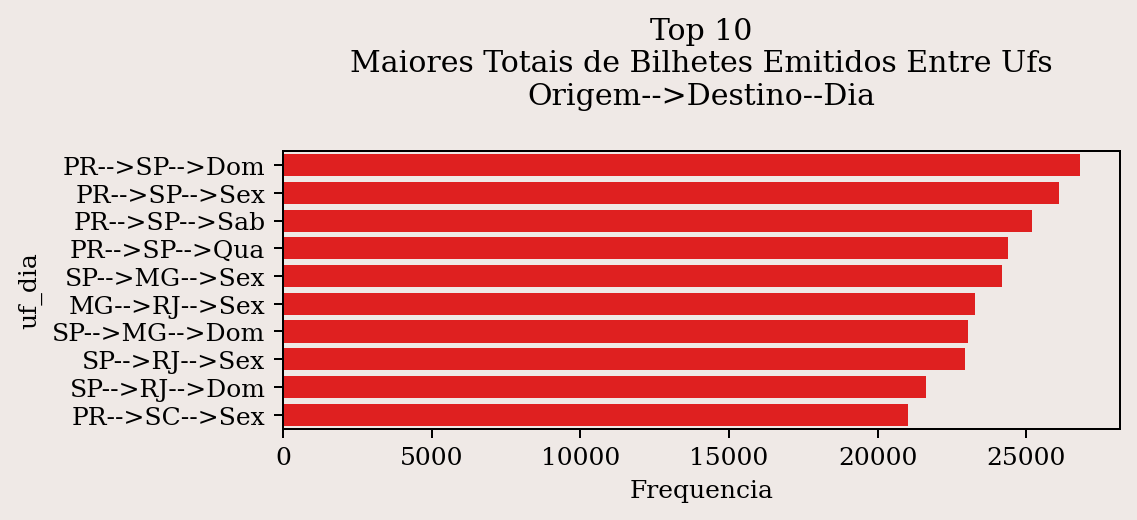

In [ ]:
# Fig9
print('\033[1m',"\n\n\tOs Estados do Paraná e São Paulo apresentam grande fluxo de viajantes e a maioria deles prefere viajar na sexta-feira ou domingo.\n\n")
fig = Image.open('/content/Fig9.png')
fig.show()

 

	A tabela mostra as linhas com maiores bilhetes emitidos.
	As cidades: São Paulo, Curitiba e Belo Horizonte,  surgem como grandes fontes de viagens entre capitais.




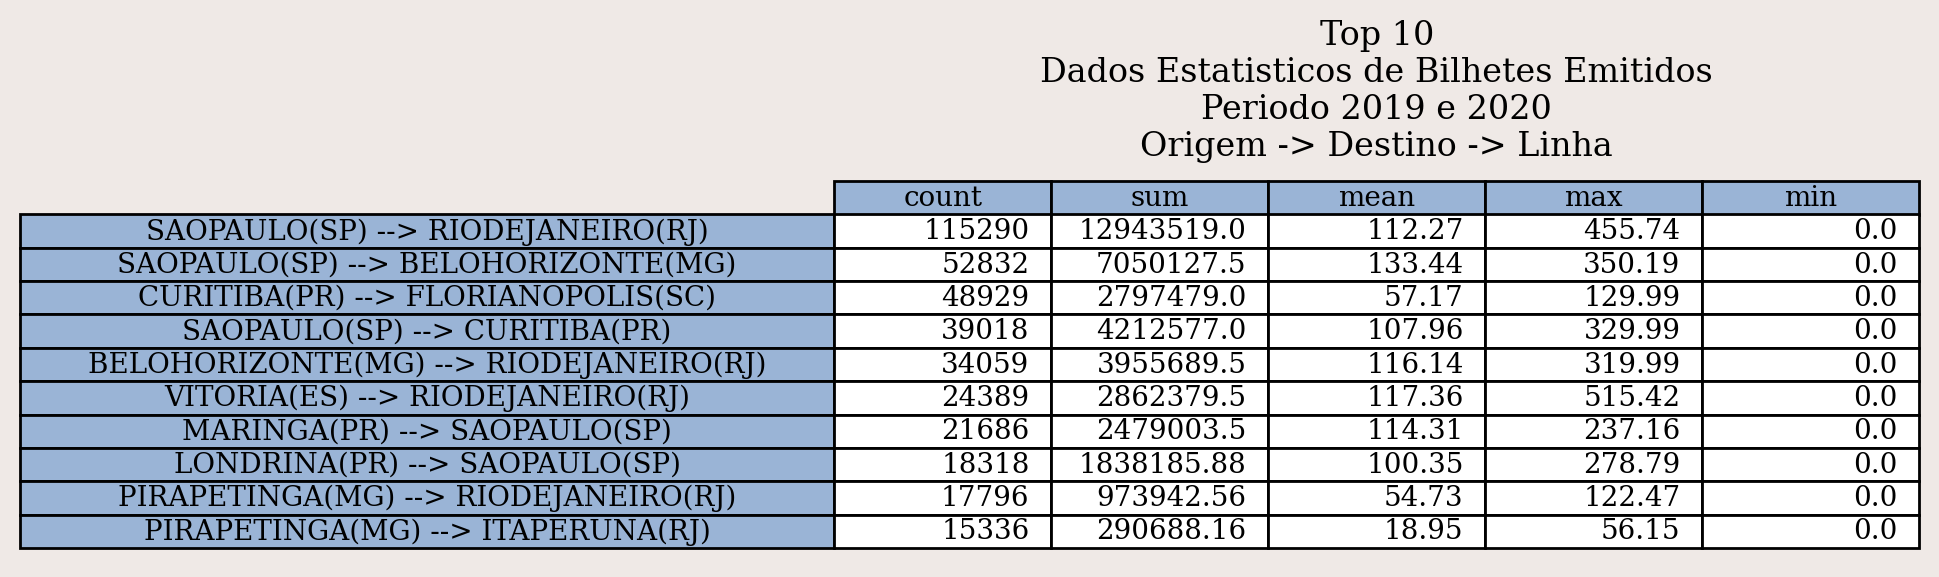

In [ ]:
# Fig10
print('\033[1m',"\n\n\tA tabela mostra as linhas com maiores bilhetes emitidos.\n\tAs cidades: São Paulo, Curitiba e Belo Horizonte,  surgem como grandes fontes de viagens entre capitais.\n\n")
fig = Image.open('/content/Fig10.png')
fig.show()

 

	Os Estados de São Paulo, Paraná e Minas Gerais respondem por um enorme fluxo de viagens.




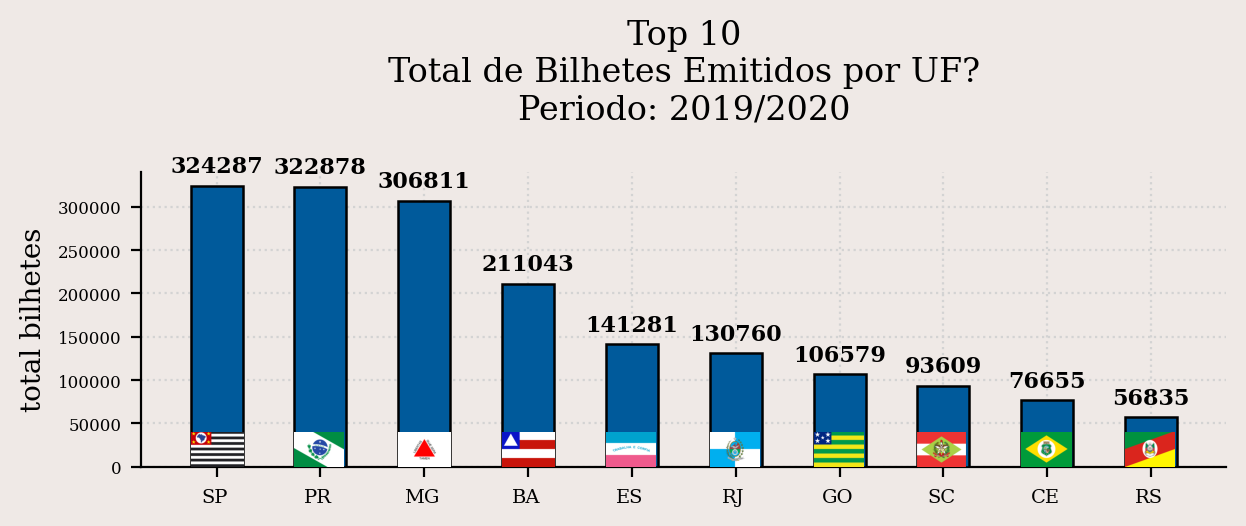

In [ ]:
# Fig11
print('\033[1m',"\n\n\tOs Estados de São Paulo, Paraná e Minas Gerais respondem por um enorme fluxo de viagens.\n\n")
fig = Image.open('/content/Fig11.png')
fig.show()